## Andrew Byrnes: Fetch Rewards Coding Exercise - Data Analyst
### 2.1-EDA_first_pass.ipynb

This notebook represents a first draft / draft as I explore the exercise questions. It does not neccessiarly contain my final answers, but is for the most part reflective of how I would start to approach these problems. My final presentation of answers can be found in 2.2-FINAL-ANSWERS.ipynb.

### Data Sources
- fetch.db: SQLite file from notebook 1-Data_Prep
- fetch_db_erd.jpg: ERD image, documenting fetch.db schema designed and created in notebook 1-Data_Prep

### Changes
- 09-21-2022 : Set up notebook
- 09-22-2022 : 

In [1]:
import pandas as pd
from pathlib import Path
import os
from datetime import datetime
import sqlite3

### File Locations

In [5]:
today = datetime.today()
print(today)
db_path = Path.cwd() / "data" / "processed" / "fetch.db"
erd_fetch_db = Path.cwd() / "data" / "interim" / "fetch_db_erd.jpg" 

2022-09-22 11:25:26.195513


### Formatting and options

In [23]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.reset_option('display.max_rows')
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_columns')

## First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

1-Data_Prep.ipynb capatures my process from start to finsih of reviewing the data, performing some transfomrations, and loading 4 tables of data into a SQLite database. 

I've structured the data as presented in this ERD:
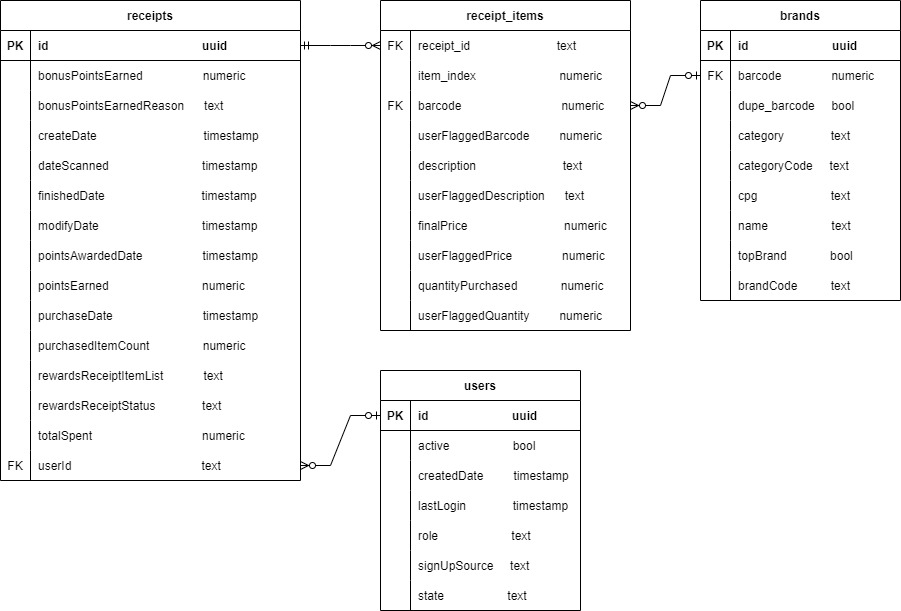  
*Note: brands.barcode <-> receipt_items is not implemented as a 0 or 1 to zero or many relationship in fetch.db as depicted above. There are duplicate values present in brands.barcode, those values are flagged in brands.dupe_barcode for easy filtering. Without filtering this join may cause unintended duplicates and in a production environment would need to be addressed.*

## Second: Write a query that directly answers a predetermined question from a business stakeholder

In [ ]:
query = f"""
        select 
            
        from
            
        where
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

###  What are the top 5 brands by receipts scanned for most recent month?
I don't want to over count receipts for a brand if multiple different items of the same brand were purchased on the same receipt. Is that a possiblity with this data and something I need to account for?

Question: are there duplicate brand names in the brands table? / is barcode 1to1 with product? / can a brand have multiple barcodes(products) on the same receipt? if so, does that receipt count once or twice?
- there are 10 brands with 2 unique barcodes each. often across different categories, but not always

Assumptions: 
- by receipts scanned: Only count a receipt once, even if it contains purchases from two distinct barcodes assoicated with the same band or two of the same barcode purchsed multiple times on the same receipt. We'll want to count unqiue receipt ids as 'scanned receipts'

- Recent Month: It looks like the receipts data was capatured on 3/1/21 around 11pm. I'm going to assume 'most recent month' refers to the most recent complete month. I'm assuming a complete month can be indicated by the preseence of values in the following month. In this case there is some data from March, so I'll assume February is the most recent, complete, month. With 444 records in February and 637 in January it seems safe to assume those are complete sets, realtive to the other three months present. 

In [77]:
# Q: Does a brands.name appear multiple times in the brands table? (Exclude known dupe barcodes)
# A: Yes, for ten brands. They each have 2 distinct barcodes

query = f"""
        select 
            b.name,
            count(b.barcode) as barcodes
        from
            brands b
        where
            b.dupe_barcode is not True
        group by
            b.name
        having
            -- only return results where the count of barcode is greater than 1
            barcodes > 1
        order by
            name
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,name,barcodes
0,Baken-Ets,2
1,Caleb's Kola,2
2,Diabetic Living Magazine,2
3,Dippin Dots® Cereal,2
4,Huggies,2
5,I CAN'T BELIEVE IT'S NOT BUTTER!,2
6,ONE A DAY® WOMENS,2
7,Pull-Ups,2
8,Sierra Mist,2
9,V8 Hydrate,2


In [78]:
"""Q: Beyond Name are there other duplicate fields for these records?
Look at the results of the brands table for all brads.name that appear mutiple times
A: It doesn't appear to be a consistent pattern - topBrand seens inconsistent, i would expect both or none
of a brand with multiple records to have topBrand values to be True or False, often there is both a True and False entry
"""

query = f"""
        with brands_w_multiple_barcodes as(
            select 
                b.name,
                count(b.barcode) as barcodes
            from
                brands b
            where
                b.dupe_barcode is not True
            group by
                b.name
            having
                -- only return results where the count of barcode is greater than 1
                barcodes > 1
            order by
                barcodes desc
        )
        
        select 
            *
        from
            brands b
        where
            b.name in  (select name from brands_w_multiple_barcodes)
        order by
            name
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,id,barcode,dupe_barcode,category,categoryCode,cpg,name,topBrand,brandCode
0,5d9d08d1a60b87376833e348,511111605546,None,Snacks,None,5332f5fbe4b03c9a25efd0ba,Baken-Ets,NaN,BAKEN ETS
1,585a961fe4b03e62d1ce0e76,511111701781,None,Snacks,None,5332f5fbe4b03c9a25efd0ba,Baken-Ets,1.0,BAKEN-ETS
2,5a4d23dae4b0bcb2c74ea77e,511111000518,None,Beverages,None,5332f5fbe4b03c9a25efd0ba,Caleb's Kola,0.0,CALEB'S KOLA
3,5d601d74a3a018514994f422,511111004912,None,Snacks,None,53e10d6368abd3c7065097cc,Caleb's Kola,NaN,CALEBS KOLA
4,5d66d597a3a018093ab34726,511111805298,None,Magazines,None,5d5d4fd16d5f3b23d1bc7905,Diabetic Living Magazine,NaN,511111805298
5,5d658ffa6d5f3b23d1bc7914,511111205227,None,None,None,53e10d6368abd3c7065097cc,Diabetic Living Magazine,NaN,None
6,5dc2d9d4a60b873d6b0666d2,511111206330,None,Breakfast & Cereal,None,5332f5f3e4b03c9a25efd0ae,Dippin Dots® Cereal,NaN,DIPPIN DOTS
7,5dc1fca91dda2c0ad7da64ae,511111706328,None,Breakfast & Cereal,None,53e10d6368abd3c7065097cc,Dippin Dots® Cereal,NaN,DIPPIN DOTS CEREAL
8,5bd2011f90fa074576779a17,511111704652,None,Baby,None,550b2565e4b001d5e9e4146f,Huggies,0.0,HUGGIES
9,5c7d9cb395144c337a3cbfbb,511111707202,None,Baby,BABY,5459429be4b0bfcb1e864082,Huggies,1.0,HUGGIES


In [32]:
# getting a sense of receipt scanned volume across different time frames - figure out how to define 'most recent month'
# generate some examples of SQL date formatting 
# ref: SQLite Date and Time Functions: https://www.sqlite.org/lang_datefunc.html
query = f"""
        select 
            -- dateScanned,
            -- date(dateScanned),
            date(dateScanned, 'start of month'),
            -- date(dateScanned, 'start of month', '-1 month'),
            count(*)
        from
            receipts
        group by
            1 
        order by 
            1 desc
        """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,"date(dateScanned, 'start of month')",count(*)
0,2021-03-01,30
1,2021-02-01,444
2,2021-01-01,637
3,2020-11-01,6
4,2020-10-01,2


In [34]:
# subquery to determine 'most recent month'
query = f"""
        select
            max(dateScanned),
            date(max(dateScanned), 'start of month')
        from
            receipts
        
            
        """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,max(dateScanned),"date(max(dateScanned), 'start of month')"
0,2021-03-01 23:17:34.772000,2021-03-01


In [100]:
# Answer
query = f"""
        select 
            b.name,
            count(ri.receipt_id) as receipts_scanned
        from
            brands b
            join receipt_items ri on coalesce(ri.barcode, ri.userFlaggedBarcode) = b.barcode
            join receipts r on r.id = ri.receipt_id
        where
            -- b.dupe_barcode is not True
            -- and 
            date(r.dateScanned) >= '2021-02-01'
                                       /*
                                       (
                                        select
                                            -- the start of the most recent month of data
                                            date(max(dateScanned), 'start of month', '-1 month')
                                        from
                                            receipts
                                        )
                                        */
                                        
        group by
            1
        order by
            2 desc
        limit 5            
        """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,name,receipts_scanned


In [93]:
# troubleshooting why i'm not getting results
query = f"""
        select 
            dateScanned
            , date(dateScanned)
        from
            receipts
        where
            date(dateScanned) >=  (
                                        select
                                            -- the start of the most recent month of data
                                            date(max(dateScanned), 'start of month', '-1 month')
                                        from
                                            receipts
                                        )
        order by
            1 desc
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,dateScanned,date(dateScanned)
0,2021-03-01 23:17:34.772000,2021-03-01
1,2021-03-01 21:32:28,2021-03-01
2,2021-03-01 21:17:27,2021-03-01
3,2021-03-01 19:27:33,2021-03-01
4,2021-03-01 18:22:30,2021-03-01
5,2021-03-01 17:47:34.867000,2021-03-01
6,2021-03-01 15:42:41.873000,2021-03-01
7,2021-03-01 14:07:37.664000,2021-03-01
8,2021-03-01 13:57:34.396000,2021-03-01
9,2021-03-01 13:07:28,2021-03-01


In [104]:
# joining to brands breaks things, I wonder if there is something wrong with barcodes after 2021-01-25
query = f"""
        select 
            r.id
            , ri.receipt_id
            , dateScanned
            , date(dateScanned)
            , ri.barcode
            , ri.userFlaggedBarcode
            , b.name
        from
            receipts r
            join receipt_items ri on ri.receipt_id = r.id
            join brands b on b.barcode = coalesce(ri.barcode, ri.userFlaggedBarcode)
        order by
            3 desc
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,id,receipt_id,dateScanned,date(dateScanned),barcode,userFlaggedBarcode,name
0,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111802358,None,Cracker Barrel Cheese
1,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111001768,None,Cheetos
2,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111602118,None,Jell-O
3,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111004127,None,V8
4,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111004127,None,V8
5,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111904175,None,Pepperidge Farm
6,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111904175,None,Pepperidge Farm
7,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111904175,None,Pepperidge Farm
8,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111704140,None,Diet Chris Cola
9,600f39c30a7214ada2000030,600f39c30a7214ada2000030,2021-01-25 21:36:03,2021-01-25,511111704140,None,Prego


In [105]:
#check out what barcodes look like on receipt_items for receipts scanned after 2021-01-25
# barcodes are in a different format after around 2/26/21, then not joining to brands

query = f"""
        select 
            r.id
            , date(r.dateScanned)
            , ri.barcode
            , ri.userFlaggedBarcode
        from
            receipts r
            join receipt_items ri on ri.receipt_id = r.id
        order by 
            2 desc
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,id,date(r.dateScanned),barcode,userFlaggedBarcode
0,603cbbb50a720fde100003e3,2021-03-01,B076FJ92M4,None
1,603cbbb50a720fde100003e3,2021-03-01,B07BRRLSVC,None
2,603d30e60a7217c72c00043f,2021-03-01,B076FJ92M4,None
3,603d30e60a7217c72c00043f,2021-03-01,B07BRRLSVC,None
4,603d5d6c0a7217c72c000463,2021-03-01,B076FJ92M4,None
5,603d5d6c0a7217c72c000463,2021-03-01,B07BRRLSVC,None
6,603d59e70a7217c72c00045f,2021-03-01,B076FJ92M4,None
7,603d59e70a7217c72c00045f,2021-03-01,B07BRRLSVC,None
8,603d40250a720fde10000459,2021-03-01,B076FJ92M4,None
9,603d40250a720fde10000459,2021-03-01,B07BRRLSVC,None


In [109]:
#examine receipts.rewardsReceiptItemList for some of the sample receipts with non consistent barcode fomrats
query = f"""
        select 
            id,
            rewardsReceiptItemList
        from
            receipts
        where
            id in ('603cbbb50a720fde100003e3', '603d30e60a7217c72c00043f', '603d5d6c0a7217c72c000463', '603ce7100a7217c72c000405')
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,id,rewardsReceiptItemList
0,603cbbb50a720fde100003e3,"[{'barcode': 'B076FJ92M4', 'description': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'discountedItemPrice': '22.97', 'finalPrice': '22.97', 'itemPrice': '22.97', 'originalReceiptItemText': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'partnerItemId': '0', 'priceAfterCoupon': '22.97', 'quantityPurchased': 1}, {'barcode': 'B07BRRLSVC', 'description': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'discountedItemPrice': '11.99', 'finalPrice': '11.99', 'itemPrice': '11.99', 'originalReceiptItemText': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'partnerItemId': '1', 'priceAfterCoupon': '11.99', 'quantityPurchased': 1}]"
1,603ce7100a7217c72c000405,"[{'barcode': 'B076FJ92M4', 'description': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'discountedItemPrice': '22.97', 'finalPrice': '22.97', 'itemPrice': '22.97', 'originalReceiptItemText': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'partnerItemId': '0', 'priceAfterCoupon': '22.97', 'quantityPurchased': 1}, {'barcode': 'B07BRRLSVC', 'description': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'discountedItemPrice': '11.99', 'finalPrice': '11.99', 'itemPrice': '11.99', 'originalReceiptItemText': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'partnerItemId': '1', 'priceAfterCoupon': '11.99', 'quantityPurchased': 1}]"
2,603d30e60a7217c72c00043f,"[{'barcode': 'B076FJ92M4', 'description': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'discountedItemPrice': '22.97', 'finalPrice': '22.97', 'itemPrice': '22.97', 'originalReceiptItemText': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'partnerItemId': '0', 'priceAfterCoupon': '22.97', 'quantityPurchased': 1}, {'barcode': 'B07BRRLSVC', 'description': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'discountedItemPrice': '11.99', 'finalPrice': '11.99', 'itemPrice': '11.99', 'originalReceiptItemText': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'partnerItemId': '1', 'priceAfterCoupon': '11.99', 'quantityPurchased': 1}]"
3,603d5d6c0a7217c72c000463,"[{'barcode': 'B076FJ92M4', 'description': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'discountedItemPrice': '22.97', 'finalPrice': '22.97', 'itemPrice': '22.97', 'originalReceiptItemText': 'mueller austria hypergrind precision electric spice/coffee grinder millwith large grinding capacity and hd motor also for spices, herbs, nuts,grains, white', 'partnerItemId': '0', 'priceAfterCoupon': '22.97', 'quantityPurchased': 1}, {'barcode': 'B07BRRLSVC', 'description': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'discountedItemPrice': '11.99', 'finalPrice': '11.99', 'itemPrice': '11.99', 'originalReceiptItemText': 'thindust summer face mask - sun protection neck gaiter for outdooractivities', 'partnerItemId': '1', 'priceAfterCoupon': '11.99', 'quantityPurchased': 1}]"


In [67]:
# looking into brands.barcode
query = f"""
        select 
            dupe_barcode
        from
            brands
        where 
            
        
            
    """
#execute the above query and save results to dataframe 
conn = sqlite3.connect(db_path)
df = pd.read_sql_query(query, conn)
conn.close()
df

,dupe_barcode
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,1.0


### How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

### Which brand has the most spend among users who were created within the past 6 months?

### Which brand has the most transactions among users who were created within the past 6 months?

## Third: Evaluate Data Quality Issues in the Data Provided

Using the programming language of your choice (SQL, Python, R, Bash, etc...) identify at least one data quality issue. We are not expecting a full blown review of all the data provided, but instead want to know how you explore and evaluate data of questionable provenance.

## Fourth: Communicate with Stakeholders

Construct an email or slack message that is understandable to a product or business leader who isn’t familiar with your day to day work. This part of the exercise should show off how you communicate and reason about data with others. Commit your answers to the git repository along with the rest of your exercise.

- What questions do you have about the data?
- How did you discover the data quality issues?
- What do you need to know to resolve the data quality issues?
- What other information would you need to help you optimize the data assets you're trying to create?
- What performance and scaling concerns do you anticipate in production and how do you plan to address them?